<h3 style="color: #2E86C1; text-decoration: underline;">Contexte du problème</h3>

Ce challenge porte sur la prédiction des rendements des actions, sur un marché boursier. Étant donné un ensemble de $ N $ actions et leurs rendements $ R_t $ à un instant $ t $, l'objectif est de concevoir à chaque instant $ t $ un vecteur $ S_{t+1} $ qui maximisera le chevauchement avec les rendements réels $ R_{t+1} $, c'est-à-dire $ \langle S_{t+1}, R_{t+1} \rangle $. Ce problème est abordé avec un modèle factoriel linéaire, où les facteurs sont appris dans un espace de paramètres non linéaire.


<h3 style="color: #2E86C1; text-decoration: underline;">Vue d'ensemble du modèle</h3>

Le modèle classique utilisé pour prédire les rendements des actions est un modèle linéaire :

$$
S_{t+1} = \sum_{\ell=1}^F \beta_\ell F_{t,\ell}
$$

Où :

- $ F_{t,\ell} $ sont des facteurs explicatifs ou des caractéristiques.
- $ \beta_1, \dots, \beta_F $ sont les paramètres du modèle qui sont appris lors de l'entraînement.

Le challenge explore également la possibilité de concevoir les facteurs eux-mêmes, où $ F_{t,\ell} $ sont des fonctions linéaires des rendements passés. Cela conduit à la formulation suivante :

$$
F_{t,\ell} = \sum_{k=1}^D A_{k\ell} R_{t+1-k}
$$

Ici :

- $ A_\ell $ sont des vecteurs qui définissent les facteurs, et
- $ D $ est la profondeur temporelle.

Les vecteurs $ A_1, \dots, A_F $ doivent être orthonormés, ce qui ajoute une contrainte non linéaire à l'espace des paramètres.

<h3 style="color: #2E86C1; text-decoration: underline;">Objectif</h3>

L'objectif est de concevoir et d'apprendre les facteurs $ F_{t,\ell} $ pour la prédiction des rendements des actions, tout en garantissant que les vecteurs $ A_1, \dots, A_F $ respectent la contrainte d'orthonormalité.

<h3 style="color: #2E86C1; text-decoration: underline;">Données</h3>

- **Données d'entraînement** : Un dataframe contenant les rendements quotidiens de 50 actions sur une période de 754 jours (3 ans) est fourni. Ces données seront utilisées pour apprendre les paramètres $ A $ et $ \beta $.
- **Données de test** : Un jeu de données de test est fourni, comportant les jours de rendements suivants les 250 jours des données d'entraînement.

<h3 style="color: #2E86C1; text-decoration: underline;">Sortie attendue</h3>

La sortie attendue des participants est un vecteur contenant les paramètres :

- Une matrice $ A $ de taille $ 250 \times 10 $, représentant les vecteurs de facteurs appris.
- Un vecteur $ \beta $ de taille $ 10 $, représentant les paramètres du modèle.

Ces sorties doivent être empilées dans un seul vecteur de taille $ 2510 $.

<h3 style="color: #2E86C1; text-decoration: underline;">Métrique d'évaluation</h3>

La performance du modèle est évaluée par une métrique qui mesure l'alignement entre les rendements prédits et les rendements réels pour les données de test, définie comme suit :

$$
M_{\text{trique}}(A, \beta) = \frac{1}{504} \sum_{t=250}^{753} \frac{\langle S_t, R_t \rangle}{\|S_t\| \|R_t\|}
$$

Si la condition d'orthonormalité $ \langle A_i, A_j \rangle = \delta_{ij} $ est violée, la métrique renverra -1. Sinon, la métrique variera entre -1 et 1.

<h3 style="color: #2E86C1; text-decoration: underline;">Stratégie de benchmarking</h3>

Une approche de base est fourni consistant à générer des vecteurs orthonormés aléatoires $ A_1, \dots, A_F $, à ajuster $ \beta $ par régression linéaire sur les données d'entraînement et à sélectionner le meilleur résultat en fonction de la métrique. La procédure de benchmark est la suivante :

1. Générer aléatoirement $ A_1, \dots, A_F $.
2. Appliquer l'algorithme de Gram-Schmidt pour garantir l'orthonormalité.
3. Ajuster $ \beta $ en utilisant la régression des moindres carrés.
4. Calculer la métrique et sélectionner le meilleur modèle.

Cela fournit une stratégie de référence pour comparer les solutions modélisées.

<h3 style="color: #2E86C1; text-decoration: underline;">Méthodologie</h3>

Dans un premier temps, nous allons définir des features classiques des facteurs de rendement connus dans la littérature, telles que :

Ensuite, à partir de ces features, nous réaliserons un premier modèle linéaire simple afin d'obtenir une valeur de la métrique d'égalité du modèle.

Nous obtiendrons ensuite un modèle non supervisé grâce à une ACP afin d'en extraire les facteurs explicatifs des rendements et d'observer les performances de ce modèle par rapport au modèle simple.

Nous effectuerons également un modèle supervisé (on verra lequel).

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [5]:
# Chargement des données
path = '/Users/kemache/Documents/GitHub/Machine-Learning-Factors-for-Stock-Market-Returns-Prediction/' 

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'
X_train = X_train.iloc[:40,:] #Jeu de données d'entrainement
X_test = X_train.iloc[40:,:] # Jeu de données de validation

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'
Y_train = Y_train.iloc[:40,:] # Jeu de données de test
Y_test = Y_train.iloc[40:,:] # Jeu du test de validation (à prédire in fine par le modèle entrainé))


# Affichage des premières lignes des datasets
print("Aperçu des données X_train:")
print(X_train.head())
print("\nAperçu des données Y_train:")
print(Y_train.head())


Aperçu des données X_train:
date             0         1         2         3         4         5  \
stocksID                                                               
0        -0.018647 -0.013002 -0.010776 -0.016676 -0.005110  0.009092   
1        -0.008254 -0.022280  0.012173 -0.006820 -0.004055  0.012912   
2        -0.008404 -0.013629 -0.006044 -0.003425 -0.009522 -0.001353   
3        -0.022734 -0.006981 -0.008568 -0.010899 -0.017981  0.002485   
4        -0.024546 -0.008315 -0.007991 -0.003515  0.007872  0.007082   

date             6         7         8         9  ...       744       745  \
stocksID                                          ...                       
0        -0.011745  0.007120 -0.008451  0.009119  ... -0.012525 -0.011716   
1        -0.001293  0.009994 -0.002747  0.001664  ...  0.014432 -0.002255   
2        -0.000637  0.007640  0.001600  0.007416  ... -0.006245 -0.001329   
3        -0.011980  0.012446 -0.010636  0.003807  ... -0.005179 -0.003442   
4    

In [6]:

# Vérification des valeurs manquantes par actif (ligne)
missing_values_per_stock = X_train.isnull().sum(axis=1)
missing_values_per_stock = missing_values_per_stock[missing_values_per_stock > 0]

if not missing_values_per_stock.empty:
    plt.figure(figsize=(10, 5))
    missing_values_per_stock.plot(kind="bar")
    plt.xlabel("Index des stocks")
    plt.ylabel("Nombre de valeurs manquantes")
    plt.title("Valeurs manquantes par actif")
    plt.show()
else:
    print("Aucune valeur manquante détectée dans X_train.")

print("Nombre de valeurs manquantes par actif:")
print(missing_values_per_stock)

# Remplacement des valeurs manquantes par la moyenne de chaque ligne
X_train = X_train.apply(lambda row: row.fillna(row.mean()), axis=1)

# Vérification après imputation
total_missing_after = X_train.isnull().sum().sum()
print(f"Total de valeurs manquantes après imputation : {total_missing_after}")





Aucune valeur manquante détectée dans X_train.
Nombre de valeurs manquantes par actif:
Series([], dtype: int64)
Total de valeurs manquantes après imputation : 0


## Analyse statistiques des données


Statistiques des actifs:
                  Mean       Std  Skewness  Kurtosis       Max       Min
stocksID                                                                
0         1.565039e-04  0.011626  0.373388  1.702471  0.059061 -0.042102
1         3.313147e-04  0.006856 -0.263619  1.613290  0.021139 -0.033115
2        -3.476568e-04  0.009378 -0.034502  0.976077  0.036398 -0.033386
3        -1.999018e-07  0.011018 -0.147188  0.981895  0.046312 -0.045707
4         1.057414e-04  0.011078 -0.132906  2.053168  0.056822 -0.046940


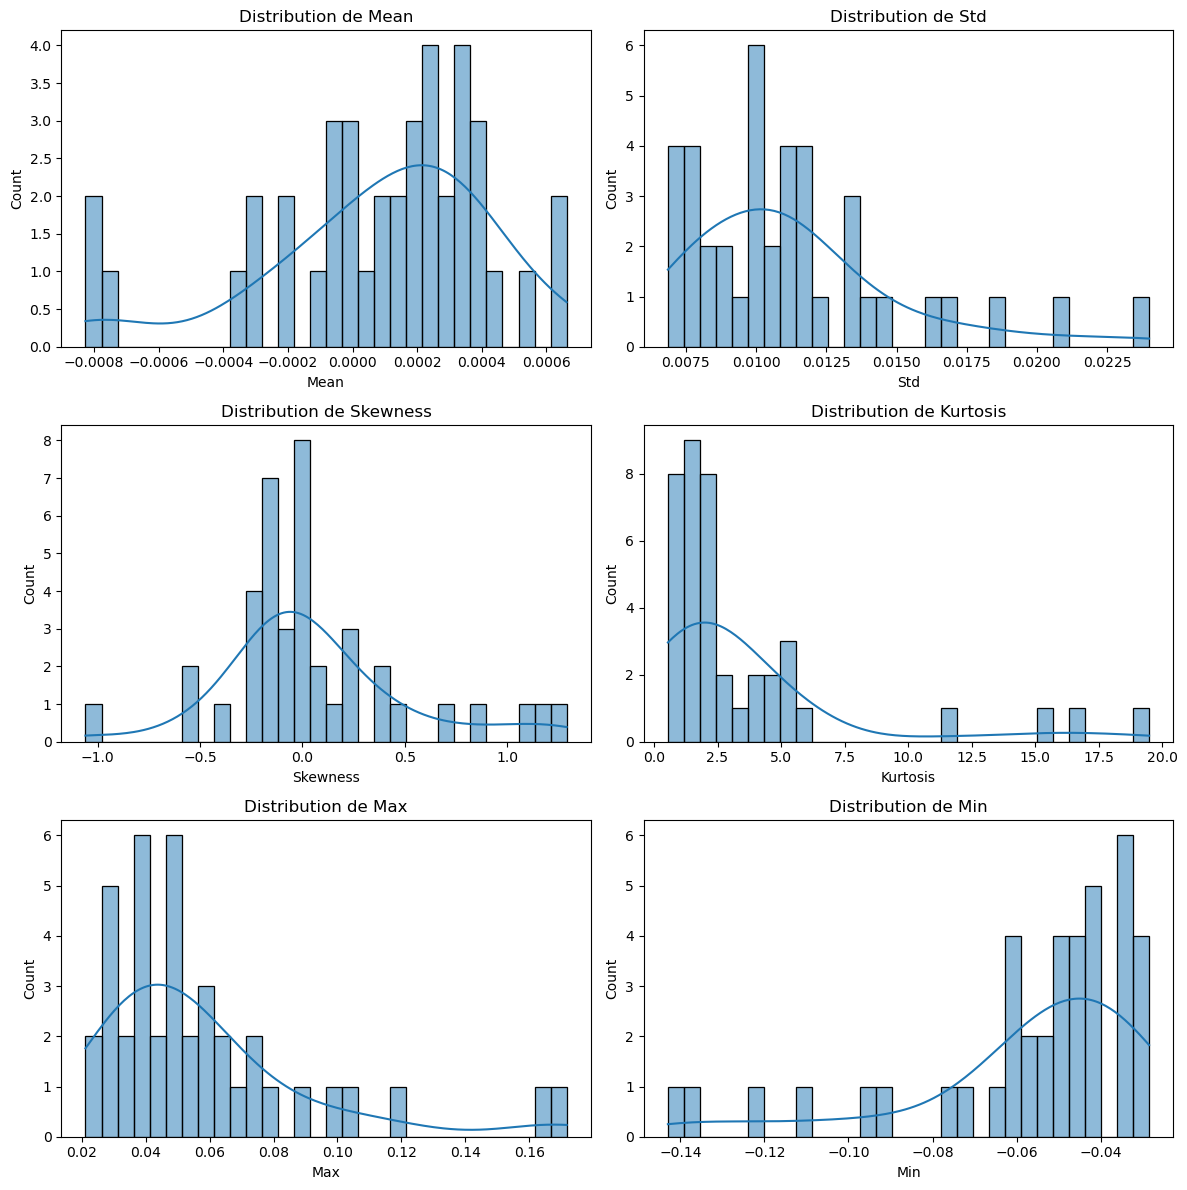

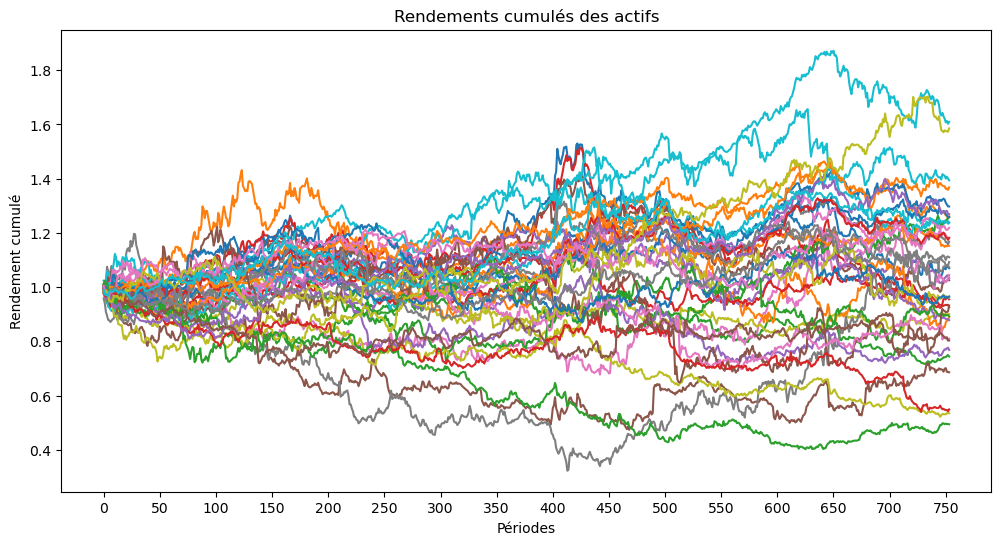

In [7]:
# Analyse statistique des données
stats_df = pd.DataFrame({
    "Mean": X_train.mean(axis=1),
    "Std": X_train.std(axis=1),
    "Skewness": X_train.skew(axis=1),
    "Kurtosis": X_train.kurtosis(axis=1),
    "Max": X_train.max(axis=1),
    "Min": X_train.min(axis=1)
})

print("\nStatistiques des actifs:")
print(stats_df.head())

# Visualisation des distributions des statistiques
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, column in enumerate(stats_df.columns):
    sns.histplot(stats_df[column], bins=30, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution de {column}")

plt.tight_layout()
plt.show()

# Calcul des rendements cumulés
cumulative_returns = (1 + X_train).cumprod(axis=1)

# Tracé des rendements cumulés
plt.figure(figsize=(12, 6))
for stock in cumulative_returns.index:
    plt.plot(cumulative_returns.columns, cumulative_returns.loc[stock])

plt.xticks(np.arange(0, len(cumulative_returns.columns), step=50))  # Affichage tous les 10 jours
plt.xlabel("Périodes")
plt.ylabel("Rendement cumulé")
plt.title("Rendements cumulés des actifs")
plt.show()

## Méthode de modélisation du Beta et de la métrique d'accuracy (issue du notebook fourni par AQR)

In [8]:
# Reshape des données : reconstruit un nouveau dataframe avec les valeurs de X_train décalées de 1 à 250 jours. Chaque ligne represente un actif et une date, et chaque colonne représente un retard.
#Exemple, pour la première ligne on a l'actif 0 (le 1er) et si tu avances dans les colonnes tu as la valeur t-1, puis t-2 etc...

X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(future_stack=False) for i in range(250) ], axis =1).dropna()
X_train_reshape.columns = pd.Index(range(1,251), name='timeLag') #Renomme les colonnes pour représenter chaque décalage temporel.


# to check the orthonormality constraints as in the metric:
def checkOrthonormality(A): 
    
    bool = True
    D, F = A.shape   
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()
    
    #if any(Error.unstack() > 1e-6):
        #bool = False
    max_error = Error.values.max()  # Erreur maximale
    if max_error > 1e-6:
        print(f"⚠️ Problème d'orthonormalité : max error = {max_error:.2e}")
        bool = False
        
    return bool

#Génération des facteurs aléatoires
def randomA(D=250, F=10):  
    
    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M
    
    return randomStiefel

#Génère un vecteur beta avec m premiers éléments non nuls
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1
    
    return beta

#Regression lineaire pour ajuster le vecteur beta à partir des facteurs A et des variables cibles Y_train
def fitBeta(A):
    
    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack() #Transposition de Y_train et mise sous un format de colonne unique
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    
    return beta.to_numpy()

#Calcul de la métrique
def metric_train(A, beta): 
    
    if not checkOrthonormality(A):
        return -1.0    
    
    Ypred = (X_train_reshape @ A @ beta).unstack().T #Prédiction avec les facteurs et les beta
    Ytrue = Y_train #Vrai valeurs des rendements
    
    # Normalisation des matrices en divisant chaque valeur par la norme (racine carrée de la somme des carrés).
    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)    
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean() #Mesure la similarité entre les prédictions et les vraies valeurs en calculant un produit scalaire moyen.


    return  meanOverlap 

## Benchmark

In [9]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):
    
    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set
    
    A = A = randomA()
    beta = fitBeta(A) # A partir des facrtors générés aléatoirement, il va prendre pour chaque point de données, les 250 données précédement formaté a partir de X_reshape et va faire une regression linéaire pour prédire les rendements futurs.
    
    # compute the metric on the training set and keep the best result   
    
    m = metric_train(A, beta)
        
    if m > maxMetric:
        print(iteration, 'metric_train:', m)
        
        maxMetric = m
        A_QRT = A
        beta_QRT = beta  

metric_train(A_QRT, beta_QRT) # public metric: 0.03535

print(f"Performance (metric_train): {maxMetric:.5f}")







0 metric_train: 0.03498249220188183
1 metric_train: 0.04175985816755471
31 metric_train: 0.046116712839033555
91 metric_train: 0.04933169735239696
421 metric_train: 0.05108624733831952
496 metric_train: 0.05151010749740387
675 metric_train: 0.05454273855058289
Performance (metric_train): 0.05454


📊 Performance du modèle :
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0597


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


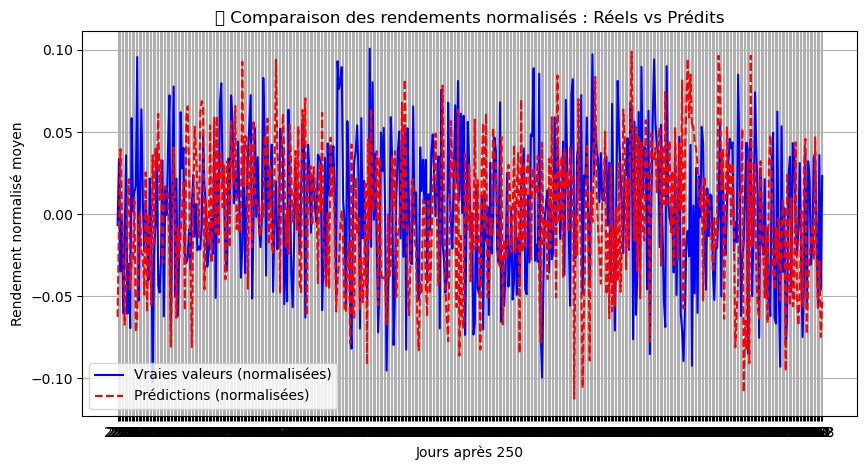

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


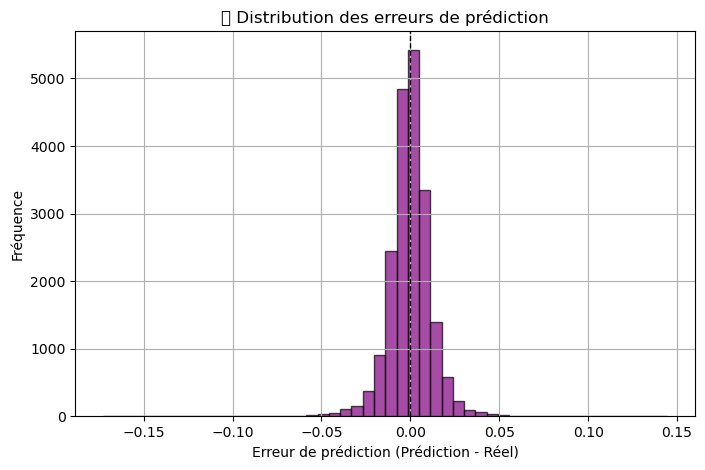

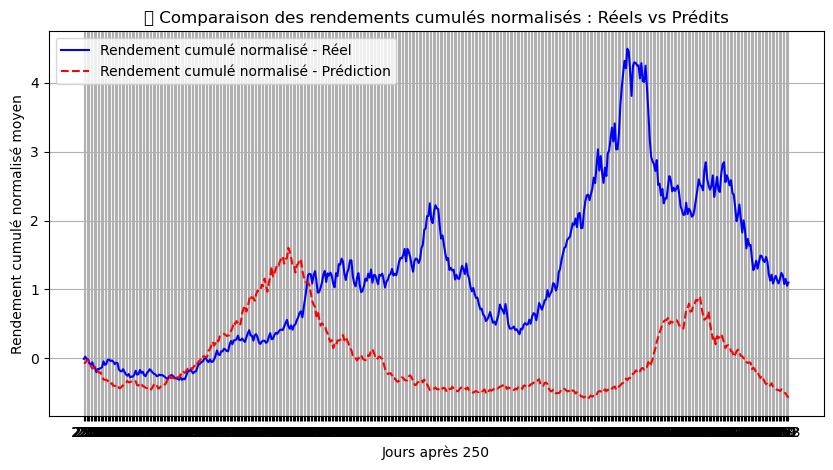

In [12]:
#Prediction du benchmark:

def predict_and_evaluate_classique(A, beta, X_train, Y_train):
    'Utilise les facteurs A et le vecteur beta pour prédire les rendements futurs et évalue les performances du modèle.'
   
    D, F = A.shape  # Dimensions de A (D=250, F=nombre de facteurs)
    T = X_train.shape[1] # Nombre total de jours dans X_train
    T_pred = T - D  
    F_t = np.zeros((X_train.shape[0], T_pred, F))     # Initialisation de la matrice des facteurs 

    # Calcul des facteurs F 
    for t in range(T_pred):  # Iteration sur chaque 250 dernière valeur pour calculer les facteurs par actifs
        X_past = X_train.iloc[:, t:t+D].values  # Pour chaque actif, on récupère les 250 jours précédents 
        F_t[:, t, :] = np.dot(X_past, A) # Calcul des facteurs pour chaque actif (40, 250) @ (250, F) -> (40, F)

    # Prédiction des rendements S_{t+1} = ∑ β * F_t
    Y_pred = np.einsum('ijk,k->ij', F_t, beta.flatten())  # Produit tensoriel (40, 504, F) @ (F,) -> (40, 504)
    Y_pred_df = pd.DataFrame(Y_pred, index=Y_train.index, columns=Y_train.columns)  # Conversion en DataFrame

    mse = mean_squared_error(Y_train.values.flatten(), Y_pred_df.values.flatten())  # Calcul du MSE
    correlation = np.corrcoef(Y_train.values.flatten(), Y_pred_df.values.flatten())[0, 1]  # Corrélation des valeurs

    # Affichage des résultats
    print(f"📊 Performance du modèle :")
    print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
    print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

    # 🔹 Plot 1 : Moyenne des valeurs prédites vs vraies valeurs
    plt.figure(figsize=(10, 5))
    plt.plot(Y_train.columns, Y_train.mean(axis=0), label="Vraies valeurs (moyenne)", color="blue")
    plt.plot(Y_train.columns, Y_pred_df.mean(axis=0), label="Prédictions (moyenne)", color="red", linestyle="dashed")
    plt.xlabel("Jours après 250")
    plt.ylabel("Rendement moyen")
    plt.title("📈 Comparaison des rendements moyens : Réels vs Prédits")
    plt.legend()
    plt.grid()
    plt.show()

    # 🔹 Plot 2 : Histogramme des erreurs
    errors = (Y_pred_df - Y_train).values.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
    plt.ylabel("Fréquence")
    plt.title("📊 Distribution des erreurs de prédiction")
    plt.grid()
    plt.show()

    # 🔹 Plot 3 : Rendement cumulé des prédictions vs des vraies valeurs (moyenne)
    plt.figure(figsize=(10, 5))
    
    cumulative_real = (1 + Y_train.mean(axis=0)).cumprod() - 1
    cumulative_pred = (1 + Y_pred_df.mean(axis=0)).cumprod() - 1

    plt.plot(Y_train.columns, cumulative_real, label="Rendement cumulé - Réel", color="blue")
    plt.plot(Y_train.columns, cumulative_pred, label="Rendement cumulé - Prédiction", color="red", linestyle="dashed")
    plt.xlabel("Jours après 250")
    plt.ylabel("Rendement cumulé moyen")
    plt.title("📈 Comparaison des rendements cumulés : Réels vs Prédits")
    plt.legend()
    plt.grid()
    plt.show()

    return mse, correlation


def predict_and_evaluate_avec_reshape(A, beta, Y_train):
    """
    Utilise les facteurs A et le vecteur beta pour prédire les rendements futurs et évalue les performances du modèle.
    """

    # 🔹 Calcul des facteurs en une seule étape (sans boucle)
    F_t = X_train_reshape @ A  # Produit matriciel direct (facteurs pour chaque actif)

    # 🔹 Prédiction des rendements futurs
    Y_pred_df = (F_t @ beta).unstack().T  # Produit matriciel pour prédire les rendements

    # 🔹 Calcul des métriques
    mse = mean_squared_error(Y_train.values.flatten(), Y_pred_df.values.flatten())
    correlation = np.corrcoef(Y_train.values.flatten(), Y_pred_df.values.flatten())[0, 1]

    print(f"📊 Performance du modèle :")
    print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
    print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

    # 🔹 Plot 1 : Moyenne des valeurs prédites vs vraies valeurs
    plt.figure(figsize=(10, 5))
    plt.plot(Y_train.columns, Y_train.mean(axis=0), label="Vraies valeurs (moyenne)", color="blue")
    plt.plot(Y_train.columns, Y_pred_df.mean(axis=0), label="Prédictions (moyenne)", color="red", linestyle="dashed")
    plt.xlabel("Jours après 250")
    plt.ylabel("Rendement moyen")
    plt.title("📈 Comparaison des rendements moyens : Réels vs Prédits")
    plt.legend()
    plt.grid()
    plt.show()

    # 🔹 Plot 2 : Histogramme des erreurs
    errors = (Y_pred_df - Y_train).values.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
    plt.ylabel("Fréquence")
    plt.title("📊 Distribution des erreurs de prédiction")
    plt.grid()
    plt.show()

    # 🔹 Plot 3 : Rendement cumulé des prédictions vs des vraies valeurs (moyenne)
    plt.figure(figsize=(10, 5))
    
    cumulative_real = (1 + Y_train.mean(axis=0)).cumprod() - 1
    cumulative_pred = (1 + Y_pred_df.mean(axis=0)).cumprod() - 1

    plt.plot(Y_train.columns, cumulative_real, label="Rendement cumulé - Réel", color="blue")
    plt.plot(Y_train.columns, cumulative_pred, label="Rendement cumulé - Prédiction", color="red", linestyle="dashed")
    plt.xlabel("Jours après 250")
    plt.ylabel("Rendement cumulé moyen")
    plt.title("📈 Comparaison des rendements cumulés : Réels vs Prédits")
    plt.legend()
    plt.grid()
    plt.show()


    return mse, correlation


def predict_and_evaluate_avec_normalisation(A, beta, Y_train):
    """
    Utilise les facteurs A et le vecteur beta pour prédire les rendements futurs et évalue les performances du modèle.
    """

    # 🔹 Calcul des facteurs en une seule étape (sans boucle)
    F_t = X_train_reshape @ A  # Produit matriciel direct (facteurs pour chaque actif)

    # 🔹 Prédiction des rendements futurs
    Y_pred_df = (F_t @ beta).unstack().T  # Produit matriciel pour prédire les rendements

    # 🔹 Normalisation des matrices (comme dans `metric_train()`)
    Ytrue = Y_train.div(np.sqrt((Y_train**2).sum()), axis=1)    
    Ypred = Y_pred_df.div(np.sqrt((Y_pred_df**2).sum()), axis=1)

    # 🔹 Calcul des métriques
    mse = mean_squared_error(Y_train.values.flatten(), Y_pred_df.values.flatten())
    correlation = np.corrcoef(Y_train.values.flatten(), Y_pred_df.values.flatten())[0, 1]

    print(f"📊 Performance du modèle :")
    print(f"✅ Erreur quadratique moyenne (MSE) : {mse:.6f}")
    print(f"✅ Corrélation entre les prédictions et les vraies valeurs : {correlation:.4f}")

    # 🔹 Plot 1 : Moyenne des valeurs prédites vs vraies valeurs (normalisées)
    plt.figure(figsize=(10, 5))
    plt.plot(Y_train.columns, Ytrue.mean(axis=0), label="Vraies valeurs (normalisées)", color="blue")
    plt.plot(Y_train.columns, Ypred.mean(axis=0), label="Prédictions (normalisées)", color="red", linestyle="dashed")
    plt.xlabel("Jours après 250")
    plt.ylabel("Rendement normalisé moyen")
    plt.title("📈 Comparaison des rendements normalisés : Réels vs Prédits")
    plt.legend()
    plt.grid()
    plt.show()

    # 🔹 Plot 2 : Histogramme des erreurs (inchangé)
    errors = (Y_pred_df - Y_train).values.flatten()
    plt.figure(figsize=(8, 5))
    plt.hist(errors, bins=50, color="purple", alpha=0.7, edgecolor="black")
    plt.axvline(0, color='black', linestyle='dashed', linewidth=1)
    plt.xlabel("Erreur de prédiction (Prédiction - Réel)")
    plt.ylabel("Fréquence")
    plt.title("📊 Distribution des erreurs de prédiction")
    plt.grid()
    plt.show()

    # 🔹 Plot 3 : Rendements cumulés normalisés (au lieu des valeurs brutes)
    plt.figure(figsize=(10, 5))
    
    cumulative_real = (1 + Ytrue.mean(axis=0)).cumprod() - 1
    cumulative_pred = (1 + Ypred.mean(axis=0)).cumprod() - 1

    plt.plot(Y_train.columns, cumulative_real, label="Rendement cumulé normalisé - Réel", color="blue")
    plt.plot(Y_train.columns, cumulative_pred, label="Rendement cumulé normalisé - Prédiction", color="red", linestyle="dashed")
    plt.xlabel("Jours après 250")
    plt.ylabel("Rendement cumulé normalisé moyen")
    plt.title("📈 Comparaison des rendements cumulés normalisés : Réels vs Prédits")
    plt.legend()
    plt.grid()
    plt.show()


    return mse, correlation





mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

Nos prédictions basées sur des facteurs générés aléatoirement échouent à capturer les dynamiques du marché.
En effet, la structure aléatoire des facteurs (moyenne =0) ne permet ni de capter les signaux financiers, ni de modéliser le bruit observé sur les marchés.

# Sélection des features


Nous travaillons sur des rendements financiers et avons sélectionné des features classiques issues de la littérature financière :

- **Momentum** : rendement cumulé sur une fenêtre déterminée, qui mesure la tendance d'un actif.
- **Volatility** : écart-type annualisé des rendements sur une période donnée, indicateur de risque.
- **Moving average** : moyenne mobile des rendements, utile pour lisser les variations et identifier des tendances.
- **RSI (Relative Strength Index)** : indicateur de surachat ou de survente basé sur la force relative des gains et pertes récents.

Nous appliquons une régression : A modifier c'est ce que je faisais au début
1. **Régression individuelle par actif** : chaque actif est modélisé séparément avec ses propres features pour obtenir des coefficients spécifiques.
2. **Régression globale** : les données sont agrégées dans un format long, permettant d'estimer des betas globaux communs à l'ensemble des actifs.

Ces deux approches permettent d’analyser les rendements sous différents angles et de comparer l’efficacité des modèles selon la granularité choisie.


Performance (metric_train): 0.03089
📊 Performance du modèle :
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0380


/Users/kemache/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


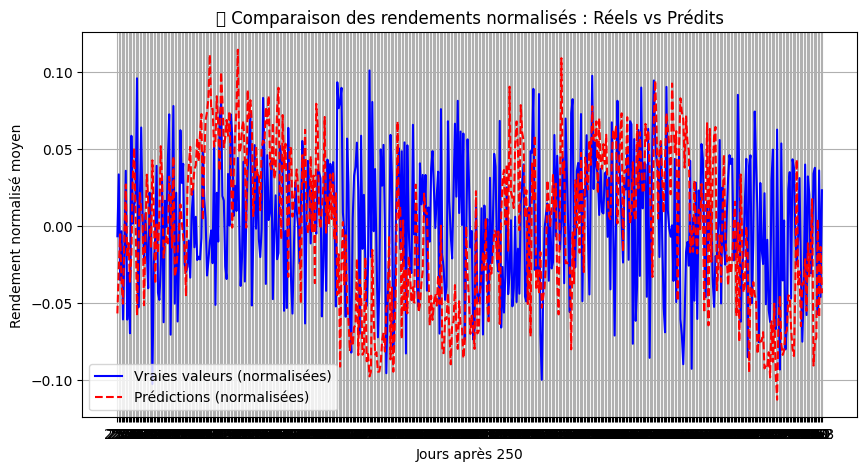

/Users/kemache/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


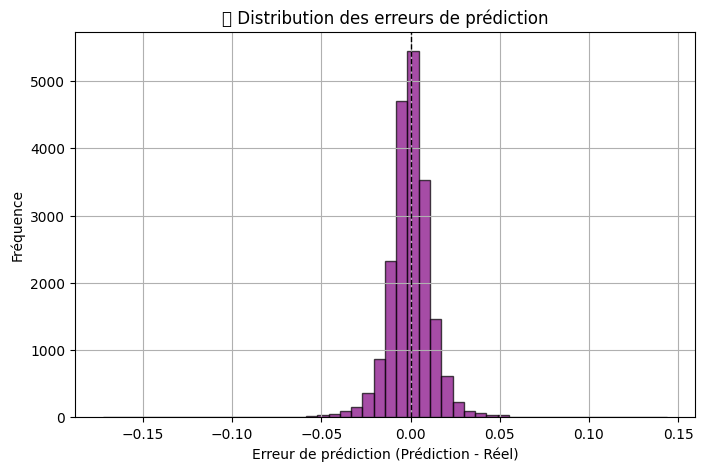

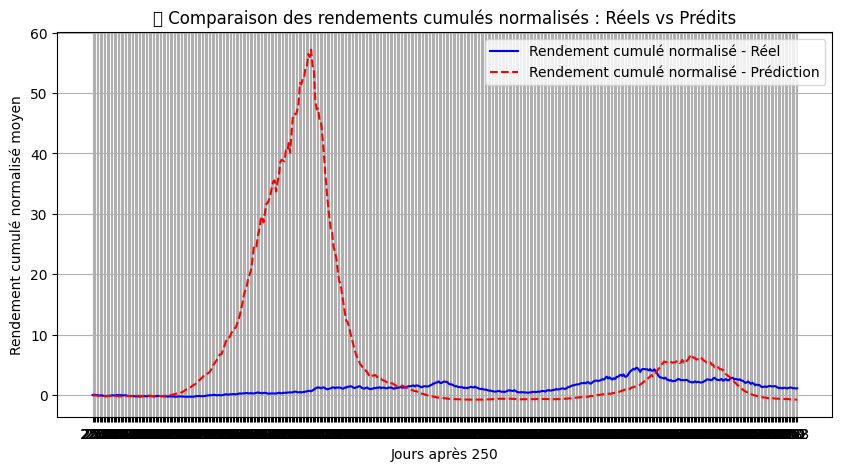

In [78]:

def compute_momentum(returns, window=21):
    """ Calcule le momentum comme rendement cumulé sur la période donnée """
    return returns.rolling(window=window).sum()

def compute_volatility(returns, window=21):
    """ Calcule la volatilité réalisée """
    return returns.rolling(window=window).std()

def compute_moving_average(price, window=21):
    """ Calcule la moyenne mobile """
    ma = price.rolling(window=window).mean()
    return price - ma

def compute_rsi(price, window=14):
    """ Calcule l'indicateur RSI, indicateur de surachat ou de suvente """
    delta = price.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() #Moyenne des rendements positifs (gains)
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean() #Moyenne des rendement negatifs (pertes)
    rs = gain / loss
    return 100 - (100 / (1 + rs)) #Transformation du rs en score RSI (plus il est important plus c'est un signe de surachat et inversement)

def compute_z_score(series):
    """Calcule le z-score pour chaque série"""
    return (series - series.mean()) / series.std()


def generate_features(X_train):
    """ Génère les features et calcule un facteur unique pour chaque date """
    feature_dict = {}
    
    # Calcul des caractéristiques pour chaque actif
    for col in X_train.columns:
        # Calcul des caractéristiques : momentum, volatilité, moyenne mobile, et RSI
        feature_dict[f'momentum_{col}'] = compute_momentum(X_train[col])
        feature_dict[f'volatility_{col}'] = compute_volatility(X_train[col])
        feature_dict[f'moving_avg_{col}'] = compute_moving_average(X_train[col])
        feature_dict[f'rsi_{col}'] = compute_rsi(X_train[col])

    features = pd.concat(feature_dict, axis=1)  # On concatène tout en une seule fois
    
    # Calcul des z-scores pour chaque caractéristique sur tous les actifs à chaque date
    features_z = features.apply(compute_z_score, axis=0)  # Normalisation

    
    # Maintenant, pour chaque date, on calcule un facteur global (moyenne des z-scores)
    # pour chaque caractéristique
    factor_momentum = features_z.filter(like="momentum").mean(axis=1)  # Moyenne des z-scores du momentum
    factor_volatility = features_z.filter(like="volatility").mean(axis=1)  # Moyenne des z-scores de la volatilité
    factor_moving_avg = features_z.filter(like="moving_avg").mean(axis=1)  # Moyenne des z-scores de la moyenne mobile
    factor_rsi = features_z.filter(like="rsi").mean(axis=1)  # Moyenne des z-scores du RSI

    # DataFrame final avec un facteur pour chaque caractéristique à chaque date
    final_features = pd.DataFrame({
        'momentum_factor': factor_momentum,
        'volatility_factor': factor_volatility,
        'moving_avg_factor': factor_moving_avg,
        'rsi_factor': factor_rsi
    })
    
    # Garde seulement les 250 premières dates
    final_features = final_features.fillna(0)
    final_features = final_features.iloc[:250]
    
    return final_features


def A_Factors(D=250, F=10):
    factors = generate_features(X_train.T).values 
    
    # On normalise les 4 facteurs pour qu'ils soient orthonormaux
    A = np.zeros((D, F))
    for i in range(4):
        A[:, i] = factors[:, i] / np.linalg.norm(factors[:, i])

    A[:, :4] = scipy.linalg.orth(A[:, :4]) # Assure l'orthonormalité
    
    if F<=4:
        return A
    
    # # # Génération des 6 autres colonnes orthonormales
    orthoProj = np.eye(D)
    for i in range(4):
        orthoProj -= np.outer(A[:, i], A[:, i])
    
    A_remaining_columns = orthoProj @ np.random.randn(D, F - 4)
    A_remaining_columns = scipy.linalg.orth(A_remaining_columns)  # Orthonormalisation

    A[:, 4:] = A_remaining_columns
    return A

# --- Pipeline principal ---
A = A_Factors()  # Génération de A avec les 4 facteurs définis
beta = fitBeta(A)  # Calcul de beta

# Vérification de la métrique
metric_value = metric_train(A, beta)

# --- Affichage des résultats ---
print(f"Performance (metric_train): {metric_value:.5f}")


mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)


#features = generate_features(X_train.T)
#features
#beta = compute_OLS(X_train.iloc[:, :250], Y_train, features)
#beta = fitBeta(features) #La meme regression que pour le benchmark, simplement avec moins de colonne dans features, mais ne fonctionne pas

#long_data = transform_to_long_format(features, X_train)
#betas_global, intercept_global = estimate_global_betas(long_data, long_data[['return']])
#betas_individual, intercepts_individual = estimate_individual_betas(features, X_train)

#m = metric_train(features, beta)




## Modèle non supervisé (clustering)


- Réduction de dimension avec PCA.
- Détermination du meilleur K avec la méthode du coude :
    Analyser l'évolution de l'inertie intra-classe en fonction du nombre de cluster. L'algoritmhe va partionner un ensemble de point en K groupes jusqu'a ce qu'un certain seuil de minimisation de l'inertie intra classe.
    L’inertie diminue forcément quand on augmente 𝐾, mais après un certain point, l'amélioration devient négligeable. Le "coude" est ce point optimal où l'ajout de clusters ne réduit plus significativement l'inertie.




- Application du clustering K-Means.
- Évaluation et ajustement des hyperparamètres (optimisation avec GridSearchCV).

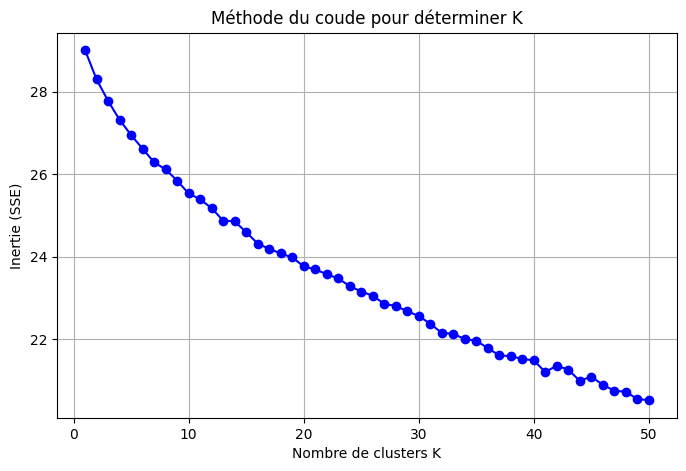

Meilleur modèle K-Means trouvé avec K=26 et init='k-means++'
Performance du modèle : 0.05418
📊 Performance du modèle :
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0623


/Users/kemache/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


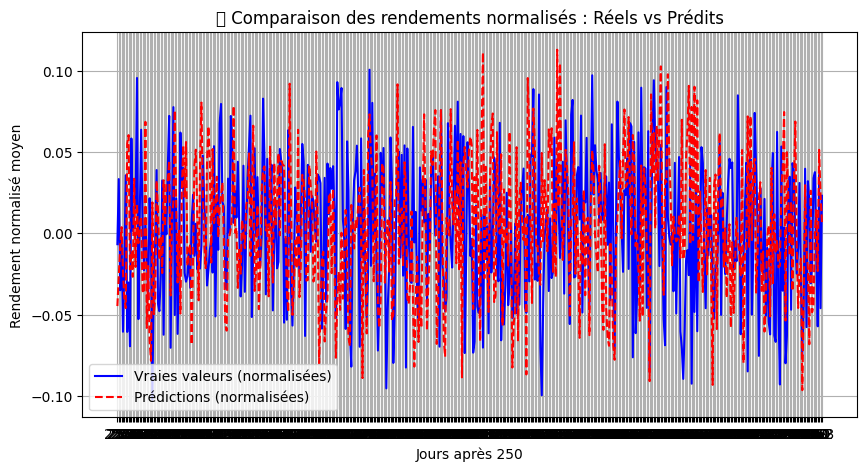

/Users/kemache/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


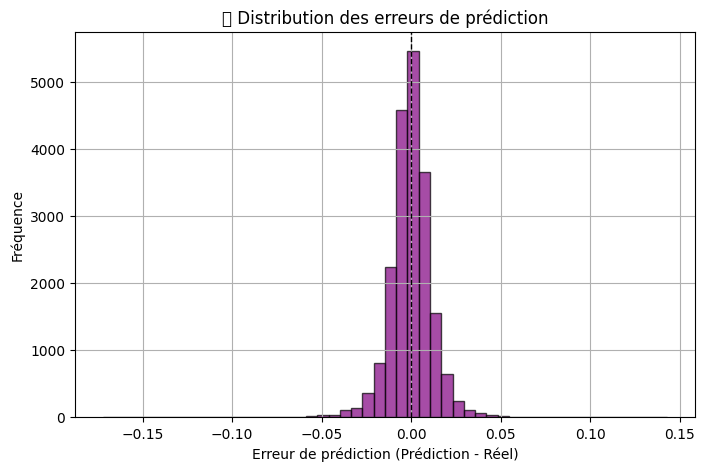

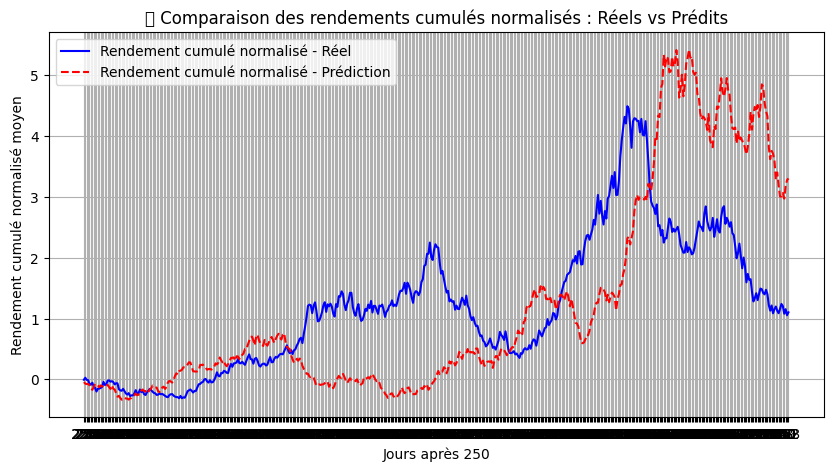

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

def find_optimal_k_elbow(X, max_k=50):
    """Utilise la méthode du coude pour déterminer le nombre optimal de clusters."""
    
    inertias = [] #Vecteur pour stocker les valeurs d'inertie
    k_values = range(1, max_k + 1) #Valeurs de K à tester
    
    #Boucle sur les valeurs de K pour calculer l'inertie
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Exécute KMeans avec K clusters  et 10 initialisations des centroides et choisit la meilleure solution
        kmeans.fit(X)  # # Entraine le modèle sur les données de X
        inertias.append(kmeans.inertia_) #Stocke la valeur de l'inertie associé à k
    
     # courbe du coude
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, inertias, marker='o', linestyle='-', color='b')
    plt.xlabel('Nombre de clusters K')
    plt.ylabel('Inertie (SSE)')
    plt.title('Méthode du coude pour déterminer K')
    plt.grid(True)
    plt.show()
    
     # Demande à l'utilisateur de choisir K, en fonction du point optimal sur le graphique, le "coude" ou la courbe commence à s'aplatir
    k_optimal = int(input("Veuillez entrer la valeur optimale de K en fonction du graphique : "))
    return k_optimal

def apply_kmeans(X, k):
    """Applique K-Means et retourne les labels et le modèle KMeans."""
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) #Initialisation du modèle KMeans
    labels = kmeans.fit_predict(X)   #entrainement du modèle et attribution des valeurs à des clusters (labels)
    return labels, kmeans

def optimize_clustering(X_train, best_k):
    """Optimise K-Means avec validation croisée manuelle et retourne le meilleur modèle."""
    
    param_grid = {'n_clusters': [best_k-1, best_k, best_k+1], 'init': ['k-means++', 'random']}
    
    best_inertia = np.inf  
    best_model = None  

    # # Validation croisée manuelle avec KFold (3 folds ici, c'est a dire qu'on divise le dataset en 3, pour entrainer sur 2 folds et tester sur la 3eme)
    kf = KFold(n_splits=3, shuffle=True, random_state=42)

    #Boucle pour parcourir chaque Hyperparamètres
    for n_clusters in param_grid['n_clusters']: #Parcours la liste de nombre de clusters qu'on souhaite tester (best_k-1, best_k, best_k+1)
        for init_method in param_grid['init']:#Parcours la liste des méthodes d'initialisation des centroides ('k-means++', 'random')
            avg_inertia = 0   # Initialisation de la variable d'inertie moyenne pour ces paramètres

            # Boucle sur les splits de la validation croisée
            for train_idx, test_idx in kf.split(X_train):
                X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx] # Sépare les données en train et test
                model = KMeans(n_clusters=n_clusters, init=init_method, random_state=42, n_init=10) #modèle KMeans avec les paramètres de le boucle
                model.fit(X_train_fold)   #Entrainement du modèle sur le jeu d'entrainement
                avg_inertia += model.inertia_   # Évalue l'inertie sur le jeu de test

            avg_inertia /= kf.get_n_splits()   # Moyenne des inerties sur tous les splits

            # Si l'inertie moyenne est meilleure (plus faible), on garde ce modèle
            if avg_inertia < best_inertia:
                best_inertia = avg_inertia
                best_model = model

    print(f"Meilleur modèle K-Means trouvé avec K={best_model.n_clusters} et init='{best_model.init}'")
    return best_model

def generate_factors_from_clusters(X_pca, best_cluster_model):
    """
    Génère la matrice A (250 jours, n_clusters) en utilisant les distances aux centroïdes.
    """
    centroids = best_cluster_model.cluster_centers_  # (n_clusters, d)


    X_pca = np.array(X_pca)  # Assure que c'est bien un tableau NumPy

    # Vérification que les dimensions sont bien alignées
    if X_pca.shape[1] != centroids.shape[1]:
        raise ValueError(f"Incompatibilité des dimensions : X_pca={X_pca.shape}, centroids={centroids.shape}")

    # Calcul des distances correctement alignées
    distances = np.linalg.norm(X_pca[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)  

    # Extraction des 250 premières lignes (jours)
    A = distances[:250, :]  # (250, n_clusters)

    A, _ = np.linalg.qr(A)  # Q est une matrice orthonormale


    return A

def compute_OLS(X_train, Y_train,features):
    predictors = X_train @ features
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets #OLS entre rendements à prédire (apres 250) et les facteurs et les rendements actuels (de 0 à 250)
    return beta.to_numpy()


# --- Pipeline principal ---
# 1. Réduction de dimension avec PCA pour X_train.T (taille initiale (50, 754))
pca = PCA(n_components=0.95)  
x_pca = pca.fit_transform(X_train.T)  # Nouvelle taille (754, d)
x_pca, _ = np.linalg.qr(x_pca)

# 2. Trouver K optimal
best_k = find_optimal_k_elbow(x_pca)

# 3. Optimiser K-Means avec validation croisée
best_cluster_model = optimize_clustering(x_pca, best_k)

# 4. Générer la matrice A (250 jours, n_clusters)
A = generate_factors_from_clusters(x_pca, best_cluster_model)

# 5. Effectuer la régression
#beta = compute_OLS(X_train.iloc[:, :250].T, Y_train, A)
#beta = compute_OLS(X_train_reshape, Y_train, A)
beta = fitBeta(A)

# 6. Calculer la métrique de performance
metric_value = metric_train(A, beta)

print(f"Performance du modèle : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)




La méthode K-Means échoue à la prévision des rendements financiers car elle est conçue pour segmenter des données en groupes homogènes et non pour prédire des valeurs futures. Cette méthode minimise la variance intra-cluster, ce qui suppose implicitement que les clusters sont sphériques et de tailles similaires. Or, les rendements financiers sont hautement volatils et bruités, ce qui empêche une séparation claire en groupes distincts. Ainsi, K-Means ne parvient pas à capturer les dynamiques de marché et à produire des facteurs pertinents pour la prédiction.

## Modèle Supervisé I : Boosting

XGBoost (Extreme Gradient Boosting) est un algorithme d’apprentissage supervisé basé sur un ensemble d’arbres de décision entraînés séquentiellement. Contrairement à un arbre de décision classique qui effectue une seule prédiction, XGBoost ajoute progressivement plusieurs arbres, où chaque nouvel arbre est entraîné pour corriger les erreurs des arbres précédents.

Dans notre cas, XGBoost est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents de marché. Le modèle commence par un premier arbre qui fait une prédiction initiale des rendements futurs. Ensuite, un second arbre est entraîné pour prédire les erreurs (résidus) du premier, et ainsi de suite. À la fin du processus, la prédiction finale est obtenue en combinant les prédictions de tous les arbres.

Afin d’assurer la robustesse et la généralisation du modèle, nous mettons  en place une validation croisée manuelle (K-Fold Cross Validation). Cette technique consiste à diviser le jeu de données en K sous-ensembles, et à entraîner XGBoost K fois, en utilisant chaque fois K-1 sous-ensembles pour l’entraînement et le dernier pour la validation. Cette approche permet de moyenner les performances du modèle sur plusieurs découpages de données, évitant ainsi qu’il ne s’adapte trop fortement à un seul jeu de données spécifique (overfitting).

De plus, nous avons mis en place une optimisation des hyperparamètres afin de sélectionner les meilleures configurations du modèle. J’ai utilisé une recherche exhaustive (ParameterGrid), qui teste différentes combinaisons de paramètres tels que :

Le nombre d’arbres (n_estimators) : Ajuste la complexité du modèle.
Le taux d’apprentissage (learning_rate) : Contrôle la vitesse d’adaptation du modèle.
La profondeur des arbres (max_depth) : Détermine le niveau de détail que chaque arbre peut capturer.
Le sous-échantillonnage (subsample) : Réduit le risque d’overfitting en utilisant une fraction des données à chaque itération.
Le nombre de caractéristiques utilisées (colsample_bytree) : Sélectionne un sous-ensemble de variables à chaque split d’un arbre.
Chaque combinaison d’hyperparamètres est évaluée à l’aide de la validation croisée, et le modèle ayant le meilleur score moyen est retenu. Pour éviter d’entraîner des modèles inutiles, j’ai aussi utilisé early_stopping_rounds, qui stoppe l’entraînement si le modèle ne s’améliore plus après un certain nombre d’itérations.

Enfin, après l’optimisation, on extrais les facteurs de marché en utilisant les valeurs des feuilles des arbres XGBoost, que je réduis avec PCA pour ne garder que les 10 facteurs les plus pertinents. Ces facteurs sont ensuite utilisés dans une régression linéaire pour prédire les rendements futurs.



In [10]:

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm  # Pour afficher la progression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# Permet d’afficher des messages de suivi à chaque étape du programme.
def log(message):
    print(f"🔄 {message}...")

# Préparation des données
def prepare_data(X_train, Y_train):
    log("Préparation des données")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

from sklearn.model_selection import KFold
import numpy as np

# Optimisation de XGBoost avec validation croisée manuelle
def optimize_xgboost(X_train, n_splits=3):
    log("Optimisation du modèle avec validation croisée manuelle")

    # 🔹 Définition des hyperparamètres à tester
    param_grid = {
        'n_estimators': [50, 100, 200],  
        'learning_rate': [0.01, 0.1, 0.2],  
        'max_depth': [3, 5, 7],  
        'subsample': [0.8, 1],  
        'colsample_bytree': [0.8, 1]  
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    # 🔹 Création de la validation croisée (K-Fold)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 🔹 Boucle sur toutes les combinaisons d’hyperparamètres
    for params in tqdm(ParameterGrid(param_grid), desc="🔍 Test d'hyperparamètres"):
        print(f"▶️ Test : {params}")  # Affichage des hyperparamètres en direct

        scores = []

        # 🔹 Validation croisée 
        for train_index, valid_index in kf.split(X_train):
            X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]

            # 🔹 Création du modèle avec les hyperparamètres actuels
            model = xgb.XGBRegressor(
                objective="reg:squarederror", 
                random_state=42, 
                verbosity=1,  
                early_stopping_rounds=10,  # Arrêt anticipé si pas d'amélioration
                **params
            )
            
            # 🔹 Entraînement avec le jeu de validation pour early stopping
            model.fit(X_train_split, X_train_split, eval_set=[(X_valid_split, X_valid_split)], verbose=False)

            # 🔹 Évaluation sur le jeu de validation
            score = model.score(X_valid_split, X_valid_split)
            scores.append(score)

        # 🔹 Moyenne des scores de validation
        mean_score = np.mean(scores)

        # 🔹 Mise à jour du meilleur modèle
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"✅ Meilleurs paramètres trouvés : {best_params}")
    return best_model


# 🔹 Extraction des facteurs après optimisation
def extract_factors_from_xgboost(model, X_train,n_factors=10):
    log("Extraction des facteurs à partir de XGBoost")

    A_xgb = model.apply(X_train) # Extrait les valeurs des feuilles de chaque arbre comme nouveaux facteurs.

    # 🔹 Réduction avec PCA pour ne pas avoir trop de facteurs
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_xgb)  # (250, n_factors)

    A_reduced, _ = np.linalg.qr(A_reduced) # Orthonormalise les facteurs.
    return A_reduced


log("Début du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
xgb_best_model = optimize_xgboost(X_train_set)
A = extract_factors_from_xgboost(xgb_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du modèle : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("🎉 Processus terminé !")


🔄 Début du processus...
🔄 Préparation des données...
🔄 Optimisation du modèle avec validation croisée manuelle...


🔍 Test d'hyperparamètres:   0%|          | 0/108 [00:00<?, ?it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   1%|          | 1/108 [00:01<02:26,  1.37s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:   2%|▏         | 2/108 [00:02<02:27,  1.39s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   3%|▎         | 3/108 [00:05<03:18,  1.89s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:   4%|▎         | 4/108 [00:07<03:40,  2.12s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   5%|▍         | 5/108 [00:12<05:19,  3.10s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:   6%|▌         | 6/108 [00:17<06:18,  3.71s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   6%|▋         | 7/108 [00:20<05:55,  3.52s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:   7%|▋         | 8/108 [00:23<05:36,  3.36s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   8%|▊         | 9/108 [00:28<06:34,  3.98s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:   9%|▉         | 10/108 [00:34<07:28,  4.58s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  10%|█         | 11/108 [00:45<10:28,  6.47s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  11%|█         | 12/108 [00:56<12:27,  7.79s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  12%|█▏        | 13/108 [00:59<10:13,  6.46s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  13%|█▎        | 14/108 [01:03<08:54,  5.69s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  14%|█▍        | 15/108 [01:10<09:26,  6.09s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  15%|█▍        | 16/108 [01:18<10:09,  6.63s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  16%|█▌        | 17/108 [01:31<12:59,  8.56s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  17%|█▋        | 18/108 [01:47<15:54, 10.60s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  18%|█▊        | 19/108 [01:48<11:37,  7.84s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  19%|█▊        | 20/108 [01:49<08:37,  5.89s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  19%|█▉        | 21/108 [01:52<06:56,  4.78s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  20%|██        | 22/108 [01:54<05:40,  3.96s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  21%|██▏       | 23/108 [01:56<05:07,  3.61s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  22%|██▏       | 24/108 [01:58<04:22,  3.13s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  23%|██▎       | 25/108 [02:01<04:00,  2.90s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  24%|██▍       | 26/108 [02:03<03:48,  2.79s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  25%|██▌       | 27/108 [02:06<03:52,  2.87s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  26%|██▌       | 28/108 [02:09<03:55,  2.95s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  27%|██▋       | 29/108 [02:13<04:04,  3.09s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  28%|██▊       | 30/108 [02:16<03:59,  3.07s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  29%|██▊       | 31/108 [02:19<03:50,  2.99s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  30%|██▉       | 32/108 [02:22<03:43,  2.94s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  31%|███       | 33/108 [02:25<03:55,  3.15s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  31%|███▏      | 34/108 [02:28<03:57,  3.21s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  32%|███▏      | 35/108 [02:32<04:10,  3.43s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  33%|███▎      | 36/108 [02:36<04:03,  3.39s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  34%|███▍      | 37/108 [02:37<03:11,  2.70s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  35%|███▌      | 38/108 [02:38<02:33,  2.20s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  36%|███▌      | 39/108 [02:39<02:18,  2.01s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  37%|███▋      | 40/108 [02:41<01:57,  1.73s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  38%|███▊      | 41/108 [02:42<01:54,  1.71s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  39%|███▉      | 42/108 [02:43<01:40,  1.53s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  40%|███▉      | 43/108 [02:45<01:44,  1.61s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  41%|████      | 44/108 [02:47<01:43,  1.62s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  42%|████▏     | 45/108 [02:49<01:49,  1.73s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  43%|████▎     | 46/108 [02:50<01:45,  1.71s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  44%|████▎     | 47/108 [02:52<01:48,  1.78s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  44%|████▍     | 48/108 [02:54<01:43,  1.72s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  45%|████▌     | 49/108 [02:56<01:45,  1.79s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  46%|████▋     | 50/108 [02:58<01:43,  1.79s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  47%|████▋     | 51/108 [03:00<01:50,  1.94s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  48%|████▊     | 52/108 [03:02<01:47,  1.92s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  49%|████▉     | 53/108 [03:04<01:52,  2.05s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  50%|█████     | 54/108 [03:06<01:45,  1.96s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  51%|█████     | 55/108 [03:07<01:35,  1.81s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  52%|█████▏    | 56/108 [03:09<01:28,  1.70s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  53%|█████▎    | 57/108 [03:12<01:42,  2.02s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  54%|█████▎    | 58/108 [03:14<01:52,  2.25s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  55%|█████▍    | 59/108 [03:20<02:36,  3.20s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  56%|█████▌    | 60/108 [03:25<03:05,  3.85s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  56%|█████▋    | 61/108 [03:28<02:50,  3.63s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  57%|█████▋    | 62/108 [03:32<02:41,  3.52s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  58%|█████▊    | 63/108 [03:37<03:09,  4.21s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  59%|█████▉    | 64/108 [03:44<03:35,  4.90s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  60%|██████    | 65/108 [03:57<05:15,  7.33s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  61%|██████    | 66/108 [04:10<06:26,  9.19s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  62%|██████▏   | 67/108 [04:16<05:28,  8.02s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  63%|██████▎   | 68/108 [04:20<04:32,  6.81s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  64%|██████▍   | 69/108 [04:26<04:21,  6.70s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  65%|██████▍   | 70/108 [04:33<04:15,  6.73s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  66%|██████▌   | 71/108 [04:45<05:04,  8.22s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  67%|██████▋   | 72/108 [04:59<06:05, 10.15s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  68%|██████▊   | 73/108 [05:01<04:24,  7.56s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  69%|██████▊   | 74/108 [05:02<03:16,  5.77s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  69%|██████▉   | 75/108 [05:04<02:32,  4.63s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  70%|███████   | 76/108 [05:06<01:59,  3.74s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  71%|███████▏  | 77/108 [05:08<01:38,  3.19s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  72%|███████▏  | 78/108 [05:10<01:22,  2.74s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  73%|███████▎  | 79/108 [05:12<01:16,  2.64s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  74%|███████▍  | 80/108 [05:15<01:13,  2.62s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  75%|███████▌  | 81/108 [05:18<01:15,  2.79s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  76%|███████▌  | 82/108 [05:22<01:20,  3.09s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  77%|███████▋  | 83/108 [05:25<01:17,  3.08s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  78%|███████▊  | 84/108 [05:28<01:14,  3.08s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  79%|███████▊  | 85/108 [05:31<01:09,  3.00s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  80%|███████▉  | 86/108 [05:33<01:03,  2.90s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  81%|████████  | 87/108 [05:36<01:00,  2.87s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  81%|████████▏ | 88/108 [05:39<00:57,  2.88s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  82%|████████▏ | 89/108 [05:42<00:54,  2.86s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  83%|████████▎ | 90/108 [05:45<00:53,  2.96s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  84%|████████▍ | 91/108 [05:46<00:40,  2.39s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  85%|████████▌ | 92/108 [05:47<00:31,  1.98s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  86%|████████▌ | 93/108 [05:48<00:26,  1.79s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  87%|████████▋ | 94/108 [05:49<00:22,  1.59s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  88%|████████▊ | 95/108 [05:51<00:19,  1.53s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  89%|████████▉ | 96/108 [05:52<00:16,  1.38s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  90%|████████▉ | 97/108 [05:53<00:16,  1.46s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  91%|█████████ | 98/108 [05:55<00:15,  1.52s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  92%|█████████▏| 99/108 [05:57<00:13,  1.52s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  93%|█████████▎| 100/108 [05:58<00:11,  1.50s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  94%|█████████▎| 101/108 [06:00<00:10,  1.53s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  94%|█████████▍| 102/108 [06:01<00:09,  1.53s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  95%|█████████▌| 103/108 [06:03<00:07,  1.53s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  96%|█████████▋| 104/108 [06:04<00:06,  1.54s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  97%|█████████▋| 105/108 [06:06<00:04,  1.55s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  98%|█████████▊| 106/108 [06:07<00:03,  1.54s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  99%|█████████▉| 107/108 [06:09<00:01,  1.56s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres: 100%|██████████| 108/108 [06:11<00:00,  3.44s/it]


✅ Meilleurs paramètres trouvés : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
🔄 Extraction des facteurs à partir de XGBoost...
(250, 10)
Performance du modèle : 0.01818


NameError: name 'predict_and_evaluate' is not defined

🔄 Début du processus...
🔄 Préparation des données...
🔄 Optimisation du modèle avec validation croisée manuelle...


🔍 Test d'hyperparamètres:   0%|          | 0/108 [00:00<?, ?it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   1%|          | 1/108 [00:00<00:47,  2.23it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:   2%|▏         | 2/108 [00:00<00:40,  2.64it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   3%|▎         | 3/108 [00:01<00:40,  2.57it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:   4%|▎         | 4/108 [00:01<00:41,  2.53it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   5%|▍         | 5/108 [00:01<00:40,  2.52it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:   6%|▌         | 6/108 [00:02<00:40,  2.55it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   6%|▋         | 7/108 [00:03<00:55,  1.83it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:   7%|▋         | 8/108 [00:03<01:01,  1.64it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:   8%|▊         | 9/108 [00:04<01:08,  1.44it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:   9%|▉         | 10/108 [00:05<01:10,  1.39it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  10%|█         | 11/108 [00:06<01:14,  1.30it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  11%|█         | 12/108 [00:07<01:12,  1.32it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  12%|█▏        | 13/108 [00:08<01:32,  1.03it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  13%|█▎        | 14/108 [00:10<01:44,  1.11s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  14%|█▍        | 15/108 [00:11<01:55,  1.24s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  15%|█▍        | 16/108 [00:13<02:00,  1.31s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  16%|█▌        | 17/108 [00:14<02:03,  1.36s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  17%|█▋        | 18/108 [00:16<02:04,  1.39s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  18%|█▊        | 19/108 [00:16<01:35,  1.07s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  19%|█▊        | 20/108 [00:16<01:15,  1.16it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  19%|█▉        | 21/108 [00:17<01:02,  1.40it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  20%|██        | 22/108 [00:17<00:53,  1.61it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  21%|██▏       | 23/108 [00:17<00:46,  1.81it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  22%|██▏       | 24/108 [00:18<00:40,  2.06it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  23%|██▎       | 25/108 [00:19<00:47,  1.74it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  24%|██▍       | 26/108 [00:19<00:51,  1.58it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  25%|██▌       | 27/108 [00:20<00:52,  1.54it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  26%|██▌       | 28/108 [00:21<00:54,  1.47it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  27%|██▋       | 29/108 [00:22<00:55,  1.43it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  28%|██▊       | 30/108 [00:22<00:55,  1.41it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  29%|██▊       | 31/108 [00:23<01:06,  1.16it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  30%|██▉       | 32/108 [00:25<01:17,  1.02s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  31%|███       | 33/108 [00:26<01:23,  1.11s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  31%|███▏      | 34/108 [00:28<01:31,  1.24s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  32%|███▏      | 35/108 [00:29<01:32,  1.26s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  33%|███▎      | 36/108 [00:30<01:33,  1.30s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  34%|███▍      | 37/108 [00:31<01:11,  1.01s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  35%|███▌      | 38/108 [00:31<00:58,  1.20it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  36%|███▌      | 39/108 [00:32<00:51,  1.34it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  37%|███▋      | 40/108 [00:32<00:42,  1.59it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  38%|███▊      | 41/108 [00:32<00:37,  1.80it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  39%|███▉      | 42/108 [00:33<00:32,  2.03it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  40%|███▉      | 43/108 [00:34<00:36,  1.76it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  41%|████      | 44/108 [00:34<00:40,  1.59it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  42%|████▏     | 45/108 [00:35<00:41,  1.52it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  43%|████▎     | 46/108 [00:36<00:42,  1.45it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  44%|████▎     | 47/108 [00:36<00:41,  1.46it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  44%|████▍     | 48/108 [00:37<00:42,  1.42it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  45%|████▌     | 49/108 [00:38<00:49,  1.20it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  46%|████▋     | 50/108 [00:40<00:55,  1.05it/s]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  47%|████▋     | 51/108 [00:41<00:57,  1.01s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  48%|████▊     | 52/108 [00:42<01:00,  1.08s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  49%|████▉     | 53/108 [00:43<01:02,  1.14s/it]

▶️ Test : {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  50%|█████     | 54/108 [00:45<01:05,  1.22s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  51%|█████     | 55/108 [00:45<00:53,  1.00s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  52%|█████▏    | 56/108 [00:46<00:41,  1.24it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  53%|█████▎    | 57/108 [00:46<00:36,  1.41it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  54%|█████▎    | 58/108 [00:46<00:30,  1.66it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  55%|█████▍    | 59/108 [00:47<00:27,  1.79it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  56%|█████▌    | 60/108 [00:47<00:24,  1.98it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  56%|█████▋    | 61/108 [00:48<00:30,  1.56it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  57%|█████▋    | 62/108 [00:49<00:31,  1.45it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  58%|█████▊    | 63/108 [00:50<00:33,  1.36it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  59%|█████▉    | 64/108 [00:51<00:33,  1.33it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  60%|██████    | 65/108 [00:51<00:34,  1.26it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  61%|██████    | 66/108 [00:52<00:33,  1.26it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  62%|██████▏   | 67/108 [00:54<00:43,  1.07s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  63%|██████▎   | 68/108 [00:56<00:49,  1.24s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  64%|██████▍   | 69/108 [00:57<00:51,  1.33s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  65%|██████▍   | 70/108 [00:59<00:52,  1.39s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  66%|██████▌   | 71/108 [01:00<00:54,  1.47s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  67%|██████▋   | 72/108 [01:02<00:53,  1.50s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  68%|██████▊   | 73/108 [01:02<00:40,  1.16s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  69%|██████▊   | 74/108 [01:03<00:31,  1.07it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  69%|██████▉   | 75/108 [01:03<00:24,  1.32it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  70%|███████   | 76/108 [01:03<00:20,  1.55it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  71%|███████▏  | 77/108 [01:04<00:17,  1.80it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  72%|███████▏  | 78/108 [01:04<00:14,  2.03it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  73%|███████▎  | 79/108 [01:05<00:17,  1.65it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  74%|███████▍  | 80/108 [01:06<00:18,  1.51it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  75%|███████▌  | 81/108 [01:07<00:19,  1.41it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  76%|███████▌  | 82/108 [01:07<00:19,  1.34it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  77%|███████▋  | 83/108 [01:08<00:19,  1.30it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  78%|███████▊  | 84/108 [01:09<00:18,  1.29it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  79%|███████▊  | 85/108 [01:10<00:22,  1.04it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  80%|███████▉  | 86/108 [01:12<00:24,  1.13s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  81%|████████  | 87/108 [01:14<00:27,  1.31s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  81%|████████▏ | 88/108 [01:16<00:29,  1.46s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  82%|████████▏ | 89/108 [01:17<00:29,  1.56s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  83%|████████▎ | 90/108 [01:19<00:28,  1.60s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  84%|████████▍ | 91/108 [01:20<00:21,  1.28s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  85%|████████▌ | 92/108 [01:20<00:16,  1.04s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  86%|████████▌ | 93/108 [01:20<00:12,  1.18it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  87%|████████▋ | 94/108 [01:21<00:09,  1.41it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  88%|████████▊ | 95/108 [01:21<00:08,  1.55it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  89%|████████▉ | 96/108 [01:22<00:06,  1.77it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  90%|████████▉ | 97/108 [01:23<00:07,  1.52it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  91%|█████████ | 98/108 [01:24<00:08,  1.21it/s]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  92%|█████████▏| 99/108 [01:26<00:11,  1.28s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  93%|█████████▎| 100/108 [01:27<00:09,  1.21s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  94%|█████████▎| 101/108 [01:28<00:08,  1.17s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres:  94%|█████████▍| 102/108 [01:29<00:06,  1.09s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  95%|█████████▌| 103/108 [01:31<00:06,  1.25s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1}


🔍 Test d'hyperparamètres:  96%|█████████▋| 104/108 [01:32<00:05,  1.36s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  97%|█████████▋| 105/108 [01:34<00:04,  1.44s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1}


🔍 Test d'hyperparamètres:  98%|█████████▊| 106/108 [01:36<00:03,  1.59s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


🔍 Test d'hyperparamètres:  99%|█████████▉| 107/108 [01:38<00:01,  1.59s/it]

▶️ Test : {'colsample_bytree': 1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1}


🔍 Test d'hyperparamètres: 100%|██████████| 108/108 [01:39<00:00,  1.08it/s]
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Meilleurs paramètres trouvés : {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
🔄 Extraction des facteurs à partir de XGBoost...
(250, 10)
Performance du modèle : 0.04038
📊 Performance du modèle :
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0437


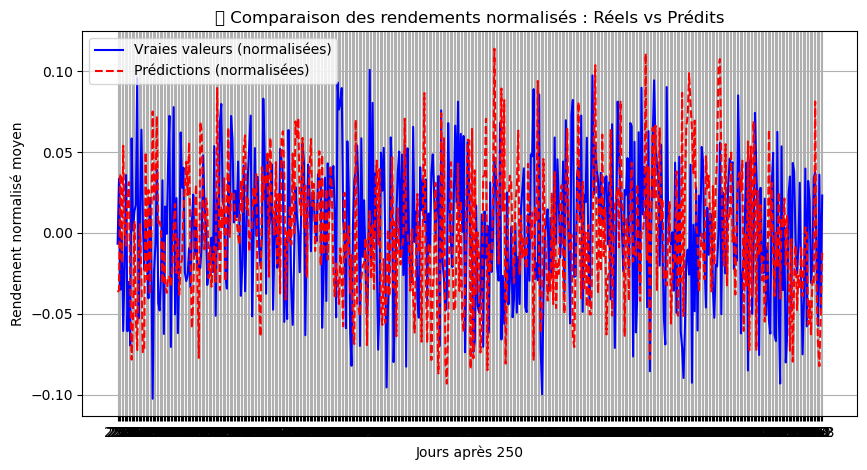

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


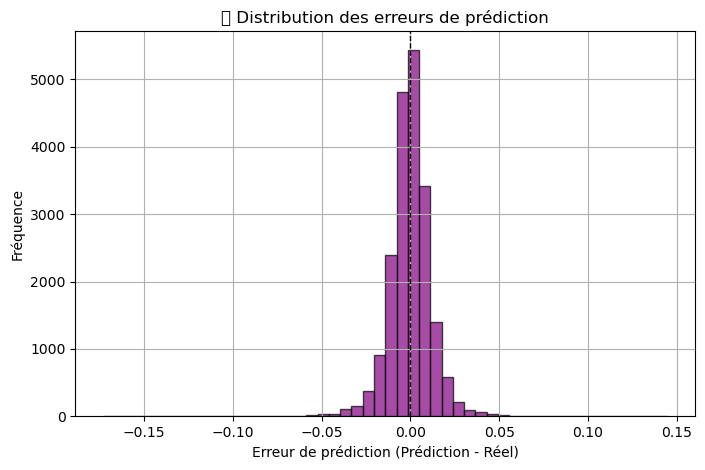

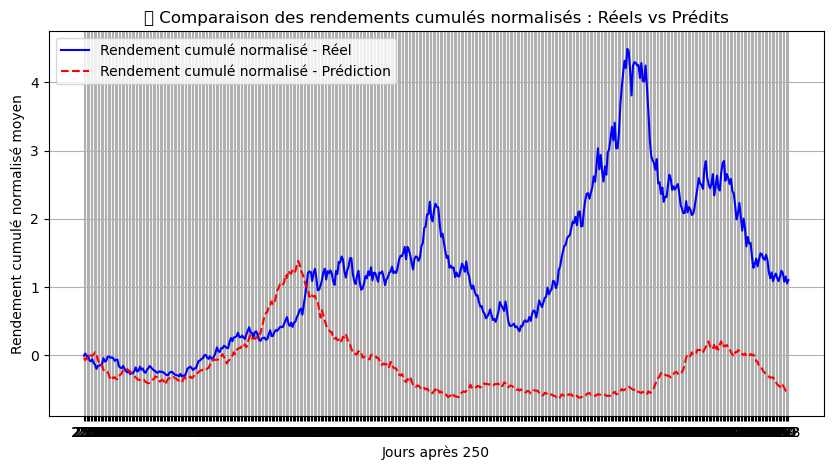

🔄 🎉 Processus terminé !...


In [26]:
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm  # Pour afficher la progression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

# Permet d’afficher des messages de suivi à chaque étape du programme.
def log(message):
    print(f"🔄 {message}...")

# Préparation des données
def prepare_data(X_train, Y_train):
    log("Préparation des données")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

from sklearn.model_selection import KFold
import numpy as np

import xgboost as xgb
import numpy as np
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

# 🔹 Fonction pour afficher des logs
def log(message):
    print(f"🔄 {message}...")

# 🔹 Optimisation de XGBoost avec validation croisée manuelle
def optimize_xgboost(X_train, Y_train, n_splits=3):
    log("Optimisation du modèle avec validation croisée manuelle")

    # 🔹 Définition des hyperparamètres à tester
    param_grid = {
        'n_estimators': [50, 100, 200],  
        'learning_rate': [0.01, 0.1, 0.2],  
        'max_depth': [3, 5, 7],  
        'subsample': [0.8, 1],  
        'colsample_bytree': [0.8, 1]  
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    # 🔹 Création de la validation croisée (K-Fold)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 🔹 Boucle sur toutes les combinaisons d’hyperparamètres
    for params in tqdm(ParameterGrid(param_grid), desc="🔍 Test d'hyperparamètres"):
        print(f"▶️ Test : {params}")  # Affichage des hyperparamètres en direct

        scores = []

        # 🔹 Validation croisée 
        for train_index, valid_index in kf.split(X_train):
            X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
            Y_train_split, Y_valid_split = Y_train.iloc[train_index], Y_train.iloc[valid_index]

            # 🔹 Création du modèle avec les hyperparamètres actuels
            model = xgb.XGBRegressor(
                objective="reg:squarederror", 
                random_state=42, 
                verbosity=1,  
                eval_metric="rmse",  # Pour que early_stopping fonctionne
                early_stopping_rounds=10,  # Arrêt anticipé si pas d'amélioration
                **params
            )
            
            # 🔹 Entraînement avec le jeu de validation pour early stopping
            model.fit(
                X_train_split, Y_train_split,  
                eval_set=[(X_valid_split, Y_valid_split)],  
                verbose=False
            )

            # 🔹 Évaluation sur le jeu de validation
            score = mean_squared_error(Y_valid_split, model.predict(X_valid_split))
            scores.append(score)

        # 🔹 Moyenne des scores de validation
        mean_score = np.mean(scores)

        # 🔹 Mise à jour du meilleur modèle
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"✅ Meilleurs paramètres trouvés : {best_params}")
    return best_model



# 🔹 Extraction des facteurs après optimisation
def extract_factors_from_xgboost(model, X_train,n_factors=10):
    log("Extraction des facteurs à partir de XGBoost")

    A_xgb = model.apply(X_train) # Extrait les valeurs des feuilles de chaque arbre comme nouveaux facteurs.

    # 🔹 Réduction avec PCA pour ne pas avoir trop de facteurs
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_xgb)  # (250, n_factors)

    A_reduced, _ = np.linalg.qr(A_reduced) # Orthonormalise les facteurs.
    return A_reduced


log("Début du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
xgb_best_model = optimize_xgboost(X_train_set,Y_train_set)
A = extract_factors_from_xgboost(xgb_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du modèle : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("🎉 Processus terminé !")


## Modèle Supervisé II : Bagging
Le Bagging (Bootstrap Aggregating) est une méthode d’ensemble qui entraîne plusieurs modèles indépendants sur des échantillons bootstrap des données. Contrairement au Boosting, qui corrige itérativement les erreurs des modèles précédents, le Bagging entraîne ses modèles en parallèle et moyenne leurs prédictions pour réduire la variance.

Dans notre cas, Bagging est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents de marché. Chaque modèle du Bagging est un arbre de décision, entraîné sur des sous-échantillons des données. L’objectif est d’obtenir un modèle robuste, réduisant la variance tout en capturant des structures complexes dans les données.

Afin d’assurer la robustesse et la généralisation du modèle, nous utilisons une validation croisée (K-Fold Cross Validation). Cette technique permet d’évaluer la stabilité du modèle en testant plusieurs découpages des données.
Nous optimisons également les hyperparamètres via une recherche sur grille (ParameterGrid), en testant différentes valeurs de :

n_estimators : Nombre d’arbres dans le modèle Bagging.
max_samples : Proportion de l’échantillon utilisée par chaque arbre.
max_features : Nombre de variables utilisées pour chaque modèle.
Enfin, après l’optimisation, nous extrayons les facteurs de marché en utilisant les prédictions des modèles entraînés, puis nous appliquons une réduction dimensionnelle via PCA pour conserver uniquement les 10 facteurs les plus pertinents.


🔄 Début du processus...
🔄 Préparation des données...
🔄 Optimisation du modèle avec validation croisée K-Fold...


🔍 Test d'hyperparamètres:   0%|          | 0/27 [00:00<?, ?it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}


🔍 Test d'hyperparamètres:   4%|▎         | 1/27 [00:00<00:11,  2.19it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 100}


🔍 Test d'hyperparamètres:   7%|▋         | 2/27 [00:01<00:16,  1.54it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  11%|█         | 3/27 [00:02<00:26,  1.09s/it]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  15%|█▍        | 4/27 [00:03<00:19,  1.19it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  19%|█▊        | 5/27 [00:04<00:19,  1.14it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.7, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  22%|██▏       | 6/27 [00:06<00:25,  1.20s/it]

▶️ Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  26%|██▌       | 7/27 [00:06<00:19,  1.01it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  30%|██▉       | 8/27 [00:07<00:19,  1.03s/it]

▶️ Test : {'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  33%|███▎      | 9/27 [00:09<00:24,  1.37s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  37%|███▋      | 10/27 [00:10<00:18,  1.10s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  41%|████      | 11/27 [00:11<00:16,  1.05s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.5, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  44%|████▍     | 12/27 [00:13<00:19,  1.30s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  48%|████▊     | 13/27 [00:13<00:14,  1.07s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  52%|█████▏    | 14/27 [00:14<00:14,  1.08s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 0.7, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  56%|█████▌    | 15/27 [00:17<00:16,  1.41s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  59%|█████▉    | 16/27 [00:17<00:13,  1.19s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  63%|██████▎   | 17/27 [00:19<00:12,  1.27s/it]

▶️ Test : {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  67%|██████▋   | 18/27 [00:21<00:15,  1.68s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  70%|███████   | 19/27 [00:22<00:10,  1.34s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  74%|███████▍  | 20/27 [00:23<00:08,  1.27s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  78%|███████▊  | 21/27 [00:25<00:09,  1.53s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  81%|████████▏ | 22/27 [00:26<00:06,  1.27s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  85%|████████▌ | 23/27 [00:27<00:05,  1.35s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 0.7, 'n_estimators': 200}


🔍 Test d'hyperparamètres:  89%|████████▉ | 24/27 [00:30<00:05,  1.75s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}


🔍 Test d'hyperparamètres:  93%|█████████▎| 25/27 [00:31<00:02,  1.48s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  96%|█████████▋| 26/27 [00:33<00:01,  1.56s/it]

▶️ Test : {'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 200}


🔍 Test d'hyperparamètres: 100%|██████████| 27/27 [00:36<00:00,  1.35s/it]

✅ Meilleurs paramètres trouvés : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 200}
🔄 Extraction des facteurs à partir de Bagging...


(250, 10)
Performance du modèle : 0.02757
📊 Performance du modèle :
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0350


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


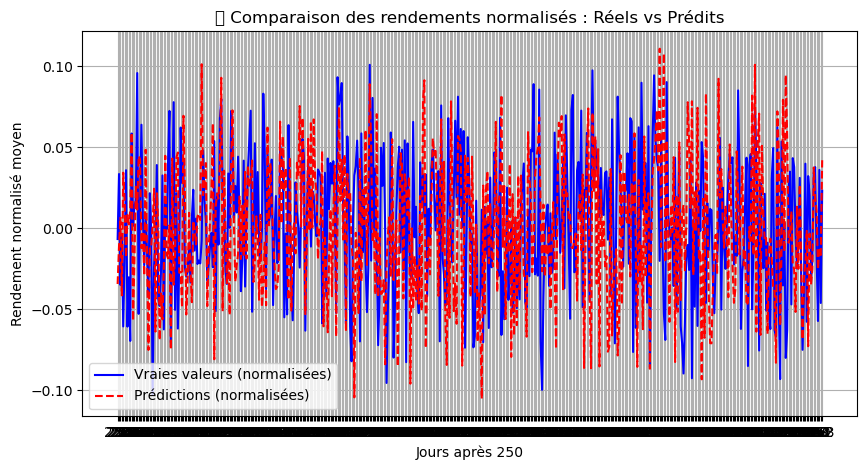

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


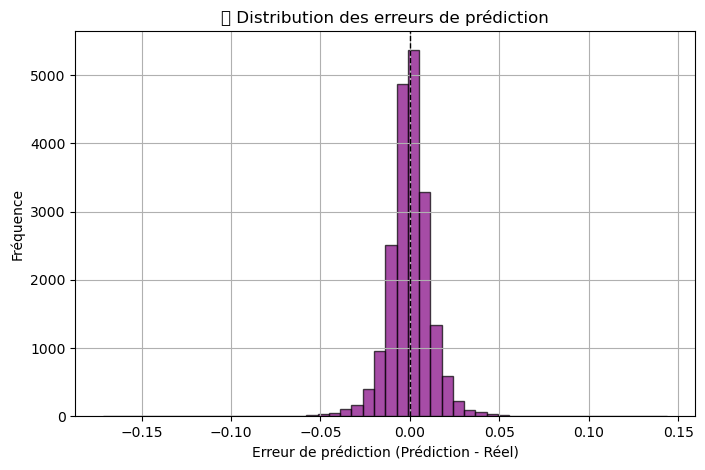

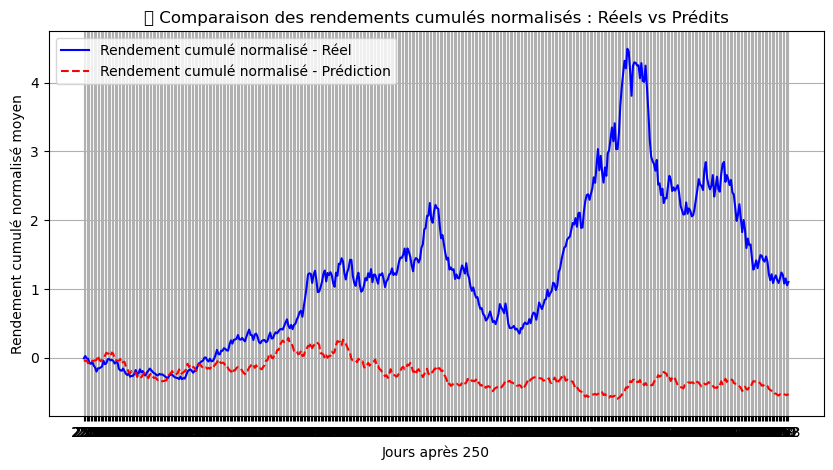

🔄 🎉 Processus terminé !...


In [34]:
import numpy as np
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # Pour afficher la progression

# 🔹 Fonction pour afficher des logs
def log(message):
    print(f"🔄 {message}...")

# 🔹 Préparation des données
def prepare_data(X_train, Y_train):
    log("Préparation des données")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

# 🔹 Optimisation du modèle Bagging avec validation croisée (K-Fold)
def optimize_bagging(X_train, Y_train, n_splits=3):
    log("Optimisation du modèle avec validation croisée K-Fold")

    param_grid = {
        'n_estimators': [50, 100, 200],  # Nombre d'arbres
        'max_samples': [0.5, 0.7, 1.0],  # Échantillonnage bootstrap
        'max_features': [0.5, 0.7, 1.0]  # Sélection aléatoire de features
    }

    best_model = None
    best_score = float('inf')
    best_params = None

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 🔹 Test de toutes les combinaisons d’hyperparamètres
    for params in tqdm(ParameterGrid(param_grid), desc="🔍 Test d'hyperparamètres"):
        print(f"▶️ Test : {params}")

        scores = []

        # 🔹 Validation croisée (K-Fold)
        for train_index, valid_index in kf.split(X_train):
            X_train_split, X_valid_split = X_train.iloc[train_index], X_train.iloc[valid_index]
            Y_train_split, Y_valid_split = Y_train.iloc[train_index], Y_train.iloc[valid_index]

            # 🔹 Création du modèle avec les hyperparamètres actuels
            model = BaggingRegressor(
                estimator=DecisionTreeRegressor(),
                random_state=42,
                **params
            )

            # 🔹 Entraînement sur l’ensemble d’apprentissage
            model.fit(X_train_split, Y_train_split)

            # 🔹 Prédiction et évaluation
            score = mean_squared_error(Y_valid_split, model.predict(X_valid_split))
            scores.append(score)

        mean_score = np.mean(scores)

        # 🔹 Mise à jour du meilleur modèle
        if mean_score < best_score:
            best_score = mean_score
            best_model = model
            best_params = params

    print(f"✅ Meilleurs paramètres trouvés : {best_params}")
    return best_model

# 🔹 Extraction des facteurs via Bagging et réduction avec PCA
def extract_factors_from_bagging(model, X_train, n_factors=10):
    log("Extraction des facteurs à partir de Bagging")

    A_bagging = model.predict(X_train)  # On prend les prédictions comme nouveaux facteurs

    # 🔹 Réduction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_bagging)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced

# 🔹 Entraînement et évaluation du modèle
log("Début du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
bagging_best_model = optimize_bagging(X_train_set, Y_train_set)
A = extract_factors_from_bagging(bagging_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du modèle : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("🎉 Processus terminé !")


In [40]:
# Utilisation du OOB Score plutot que CV-Kfold mais soucis de dimension entre X Train & Y Train
import numpy as np
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from tqdm import tqdm  # Pour afficher la progression

# 🔹 Fonction pour afficher des logs
def log(message):
    print(f"🔄 {message}...")

# 🔹 Préparation des données
def prepare_data(X_train, Y_train):
    log("Préparation des données")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

# 🔹 Optimisation du modèle Bagging en utilisant OOB Score
def optimize_bagging_oob(X_train,Y_train):
    log("Optimisation du modèle avec OOB Score")

    param_grid = {
        'n_estimators': [50, 100, 200],  # Nombre d'arbres
        'max_samples': [0.5, 0.7, 1.0],  # Pourcentage de l'échantillon utilisé par chaque arbre
        'max_features': [0.5, 0.7, 1.0]  # Proportion des features utilisées
    }

    best_model = None
    best_oob_score = float('-inf')  # OOB Score doit être maximisé
    best_params = None

    for params in tqdm(ParameterGrid(param_grid), desc="🔍 Test d'hyperparamètres"):
        print(f"▶️ Test : {params}")

        # 🔹 Création du modèle avec les paramètres actuels
        model = BaggingRegressor(
            estimator=DecisionTreeRegressor(),
            oob_score=True,  # Activation du OOB Score
            random_state=42,
            **params
        )

        model.fit(X_train, Y_train)  # Pas de validation croisée ici, OOB gère ça

        # 🔹 Récupération du OOB Score
        oob_score = model.oob_score_

        if oob_score > best_oob_score:  # On veut maximiser le OOB Score
            best_oob_score = oob_score
            best_model = model
            best_params = params

    print(f"✅ Meilleurs paramètres trouvés : {best_params} avec OOB Score = {best_oob_score:.4f}")
    return best_model

# 🔹 Extraction des facteurs via Bagging et réduction avec PCA
def extract_factors_from_bagging(model, X_train, n_factors=10):
    log("Extraction des facteurs à partir de Bagging")

    A_bagging = model.predict(X_train) # Prédictions utilisées comme facteurs

    # 🔹 Réduction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_bagging)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced

# 🔹 Entraînement et évaluation du modèle
log("Début du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
bagging_best_model = optimize_bagging_oob(X_train_set,Y_train_set)
A = extract_factors_from_bagging(bagging_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du modèle : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("🎉 Processus terminé !")


🔄 Début du processus...
🔄 Préparation des données...
🔄 Optimisation du modèle avec OOB Score...


🔍 Test d'hyperparamètres:   0%|          | 0/27 [00:00<?, ?it/s]

▶️ Test : {'max_features': 0.5, 'max_samples': 0.5, 'n_estimators': 50}


ValueError: operands could not be broadcast together with shapes (157,) (157,40) (157,) 

## Modèle Supervisé III : Random Forest
Le Random Forest est une méthode d’ensemble basée sur l’agrégation de plusieurs arbres de décision. Contrairement à un simple arbre de décision, qui est sujet au sur-apprentissage, Random Forest construit plusieurs arbres indépendants et moyenne leurs prédictions pour réduire la variance et améliorer la robustesse du modèle.

Dans notre cas, Random Forest est utilisé pour modéliser la relation entre les rendements passés et les facteurs latents du marché. Chaque arbre est entraîné sur un sous-échantillon des données, et une sélection aléatoire des variables est effectuée à chaque division (split). Cela permet d’introduire de la diversité dans les modèles et d’éviter un sur-ajustement à certaines variables spécifiques.

Afin d’assurer la robustesse et la généralisation du modèle, nous utilisons l’Out-Of-Bag (OOB) Score, qui permet d’évaluer la performance sans avoir recours à une validation croisée classique. L’OOB Score est calculé en utilisant les observations qui ne sont pas sélectionnées dans l’échantillonnage bootstrap, offrant ainsi une estimation fiable de l’erreur du modèle.

Nous optimisons également les hyperparamètres via une recherche sur grille (Grid Search), en testant différentes valeurs de :

n_estimators : Nombre d’arbres dans la forêt.
max_features : Nombre de variables considérées pour chaque split, avec des valeurs comme sqrt, log2 ou une fraction du nombre total de variables.
Enfin, après l’optimisation, nous extrayons les facteurs de marché en utilisant les prédictions du modèle entraîné, puis nous appliquons une réduction dimensionnelle via PCA pour conserver uniquement les 10 facteurs les plus pertinents.

🔄 Début du processus...
🔄 Préparation des données...
🔄 Optimisation du modèle Random Forest avec OOB Score...


🔍 Test d'hyperparamètres:  11%|█         | 1/9 [00:00<00:01,  7.57it/s]

▶️ Test : {'max_features': 'sqrt', 'n_estimators': 50}
▶️ Test : {'max_features': 'sqrt', 'n_estimators': 100}


🔍 Test d'hyperparamètres:  33%|███▎      | 3/9 [00:00<00:00,  8.17it/s]

▶️ Test : {'max_features': 'sqrt', 'n_estimators': 200}
▶️ Test : {'max_features': 'log2', 'n_estimators': 50}


🔍 Test d'hyperparamètres:  56%|█████▌    | 5/9 [00:00<00:00, 10.30it/s]

▶️ Test : {'max_features': 'log2', 'n_estimators': 100}
▶️ Test : {'max_features': 'log2', 'n_estimators': 200}


🔍 Test d'hyperparamètres:  78%|███████▊  | 7/9 [00:00<00:00,  8.96it/s]

▶️ Test : {'max_features': 0.5, 'n_estimators': 50}
▶️ Test : {'max_features': 0.5, 'n_estimators': 100}


🔍 Test d'hyperparamètres:  89%|████████▉ | 8/9 [00:00<00:00,  8.56it/s]

▶️ Test : {'max_features': 0.5, 'n_estimators': 200}


🔍 Test d'hyperparamètres: 100%|██████████| 9/9 [00:01<00:00,  7.39it/s]
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


✅ Meilleurs paramètres trouvés : {'max_features': 'log2', 'n_estimators': 200} avec OOB Score = -0.0391
🔄 Extraction des facteurs à partir de Random Forest...
(250, 10)
Performance du modèle : 0.02341
📊 Performance du modèle :
✅ Erreur quadratique moyenne (MSE) : 0.000147
✅ Corrélation entre les prédictions et les vraies valeurs : 0.0299


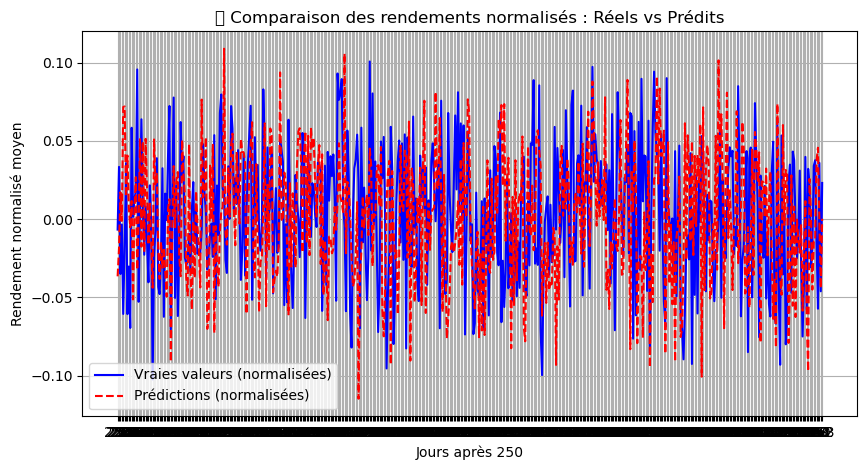

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


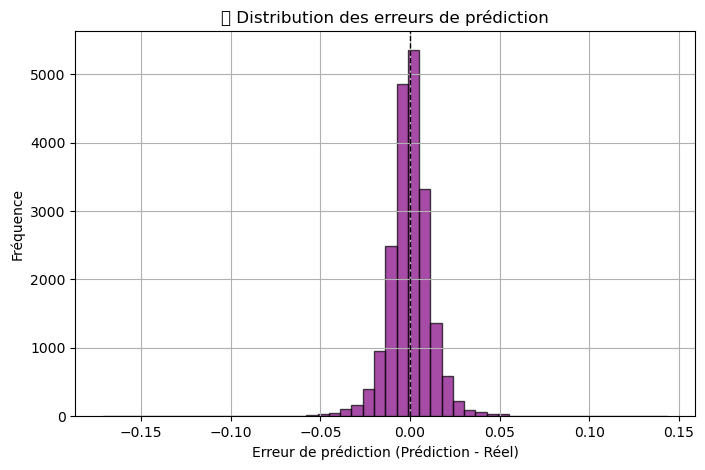

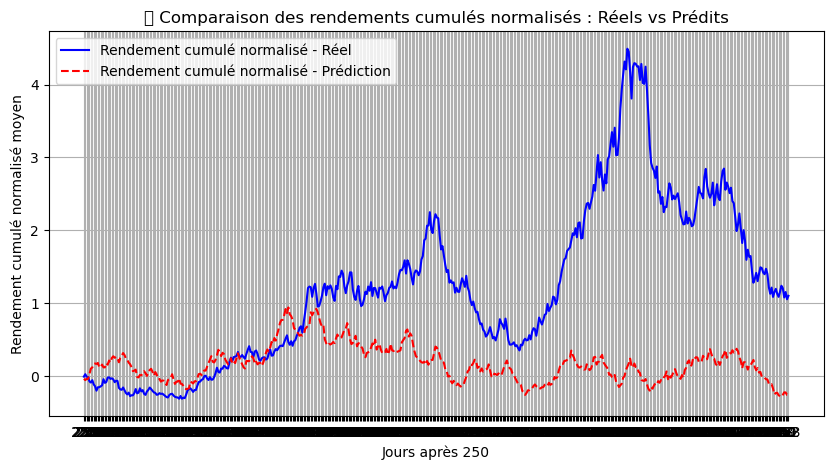

🔄 🎉 Processus terminé !...


In [28]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from tqdm import tqdm  # Pour afficher la progression

# 🔹 Fonction pour afficher des logs
def log(message):
    print(f"🔄 {message}...")

# 🔹 Préparation des données
def prepare_data(X_train, Y_train):
    log("Préparation des données")
    X_train_set = X_train.iloc[:, :250].T
    Y_train_set = Y_train.iloc[:, :250].T
    return X_train_set, Y_train_set

# 🔹 Optimisation du modèle Random Forest en utilisant OOB Score
def optimize_random_forest_oob(X_train, Y_train):
    log("Optimisation du modèle Random Forest avec OOB Score")

    param_grid = {
        'n_estimators': [50, 100, 200],  # Nombre d'arbres
        'max_features': ['sqrt', 'log2', 0.5]  # Sélection aléatoire des features
    }

    best_model = None
    best_oob_score = float('-inf')
    best_params = None

    for params in tqdm(ParameterGrid(param_grid), desc="🔍 Test d'hyperparamètres"):
        print(f"▶️ Test : {params}")

        # 🔹 Création du modèle avec les paramètres actuels
        model = RandomForestRegressor(
            oob_score=True,  # Activation du OOB Score
            random_state=42,
            n_jobs=-1,  # Utilisation de tous les cœurs pour accélérer l'entraînement
            **params
        )

        model.fit(X_train, Y_train)  # OOB est calculé automatiquement

        # 🔹 Vérification du OOB Score
        if hasattr(model, "oob_score_"):  # Parfois oob_score_ peut ne pas exister
            oob_score = model.oob_score_
        else:
            oob_score = float('-inf')

        if oob_score > best_oob_score:  # Maximisation du OOB Score
            best_oob_score = oob_score
            best_model = model
            best_params = params

    print(f"✅ Meilleurs paramètres trouvés : {best_params} avec OOB Score = {best_oob_score:.4f}")
    return best_model

# 🔹 Extraction des facteurs via Random Forest et réduction avec PCA
def extract_factors_from_rf(model, X_train, n_factors=10):
    log("Extraction des facteurs à partir de Random Forest")

    A_rf = model.predict(X_train)  # Prédictions utilisées comme facteurs

    # 🔹 Réduction avec PCA
    pca = PCA(n_components=n_factors)
    A_reduced = pca.fit_transform(A_rf)

    A_reduced, _ = np.linalg.qr(A_reduced)  # Orthonormalisation
    return A_reduced

# 🔹 Entraînement et évaluation du modèle
log("Début du processus")

X_train_set, Y_train_set = prepare_data(X_train, Y_train)
rf_best_model = optimize_random_forest_oob(X_train_set, Y_train_set)
A = extract_factors_from_rf(rf_best_model, X_train_set, n_factors=10)

print(A.shape)

beta = fitBeta(A)
metric_value = metric_train(A, beta)
print(f"Performance du modèle : {metric_value:.5f}")

mse, corr = predict_and_evaluate_avec_normalisation(A, beta, Y_train)

log("🎉 Processus terminé !")
